In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

import numpy as np
import tensorflow as tf

# Read recipe inputs
headlines_ds = dataiku.Dataset("abcnews_date_text")
headlines = headlines_ds.get_dataframe(columns=["headline_text"])["headline_text"]

In [4]:
headlines[0]

'aba decides against community broadcasting licence'

In [5]:
# this iterates over each of the headlines and creates tuples
# for consecutive characters

import itertools as it

def sliding_window(txt):
    for i in range(len(txt) - 2):
        yield txt[i], txt[i + 1], txt[i + 2]

window = list(it.chain(*[sliding_window(_) for _ in headlines[:10000]]))

In [7]:
# window

In [8]:
# create mapping dictionary for each character and back
char2ix = {c: i for i, c in enumerate(pd.DataFrame(window)[0].unique())}
ix2char = {v:k for k,v in char2ix.items()}

# mapping inputs and outputs (outputs need to be different shape)
integers_in = np.array([[char2ix[w[0]], char2ix[w[1]]] for w in window])
integers_out = np.array([char2ix[w[2]] for w in window]).reshape(-1, 1)

# total classes
num_letters = len(char2ix) # 26 letters + 10 numbers + SPACE

In [11]:
integers_in

array([[ 0,  1],
       [ 1,  0],
       [ 0,  2],
       ...,
       [ 0, 16],
       [16, 16],
       [16, 11]])

In [12]:
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.models import Sequential

# this one is so we might grab the embeddings
model_emb = Sequential()
embedding = Embedding(num_letters, 2, input_length=2)
model_emb.add(embedding)
output_array = model_emb.predict(integers_in)
output_array.shape

(376880, 2, 2)

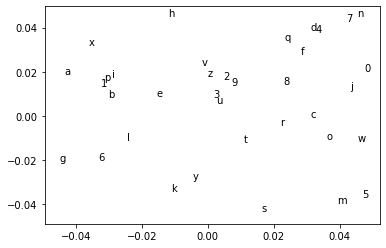

In [13]:
import matplotlib.pylab as plt

idx_to_calc = list(char2ix.values())
idx_to_calc = np.array([idx_to_calc]).T

preds = model_emb.predict(idx_to_calc)

plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
    plt.text(preds[i, 0, 0], preds[i, 0, 1], ix2char[idx[0]])

In [14]:
from tensorflow.keras.optimizers import Adam

# this one is so we might learn the mapping
model_pred = Sequential()
model_pred.add(embedding)
model_pred.add(Flatten())
model_pred.add(Dense(num_letters, activation="softmax"))

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_pred.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

output_array = model_pred.predict(integers_in)
output_array.shape

(376880, 37)

In [15]:
from sklearn.preprocessing import OneHotEncoder

to_predict = OneHotEncoder(sparse=False).fit_transform(integers_out)
model_pred.fit(integers_in, to_predict, epochs=15, verbose=1)

Epoch 1/15
11778/11778 [==============================] - 14s 1ms/step - loss: 2.8285 - accuracy: 0.1810 0s - loss: 2.8304 - accura
Epoch 2/15
11778/11778 [==============================] - 14s 1ms/step - loss: 2.5876 - accuracy: 0.2276
Epoch 3/15
11778/11778 [==============================] - 18s 2ms/step - loss: 2.5770 - accuracy: 0.2297
Epoch 4/15
11778/11778 [==============================] - 14s 1ms/step - loss: 2.5729 - accuracy: 0.2306
Epoch 5/15
11778/11778 [==============================] - 13s 1ms/step - loss: 2.5719 - accuracy: 0.2282
Epoch 6/15
11778/11778 [==============================] - 13s 1ms/step - loss: 2.5710 - accuracy: 0.2307
Epoch 7/15
11778/11778 [==============================] - 12s 981us/step - loss: 2.5716 - accuracy: 0.2290
Epoch 8/15
11778/11778 [==============================] - 12s 1ms/step - loss: 2.5690 - accuracy: 0.2302
Epoch 9/15
11778/11778 [==============================] - 9s 790us/step - loss: 2.5693 - accuracy: 0.2315
Epoch 10/15
11778/11778 [

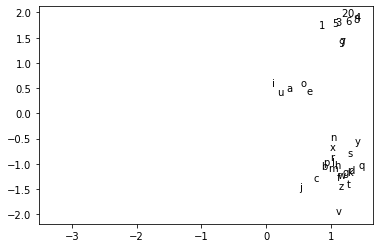

In [16]:
preds = model_emb.predict(idx_to_calc)
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
    plt.text(preds[i, 0, 0], preds[i, 0, 1], ix2char[idx[0]])

In [17]:
data = list(zip(list(char2ix.keys()), np.squeeze(preds).tolist()))
df = pd.DataFrame(columns=["char", "embedding"], data=data)

ds = dataiku.Dataset("embeddings_two_letters")
ds.write_with_schema(df)

37 rows successfully written (ytnR393Jyb)


In [20]:
ab = np.array([ 0,  1])
model_emb.predict(ab)

array([[[ 0.32116243,  0.44502077]],

       [[ 0.84703153, -1.1136465 ]]], dtype=float32)

In [21]:
# ix2char